In [1]:
using LinearAlgebra, Plots
DEV = true
if DEV    # use local package
    include("../src/EDKit.jl")
    using .EDKit
else      # use EDKit in the Pkg system
    using EDKit
end

## Spin-1/2 XY model
We consider the Hamiltonian
$$
H = \sum_i (S_i^x S_{i+1}^x + S_i^y S_{i+1}^y).
$$
First, without considering any symmetry, we can construct the many-body Hamiltonian canonically, by creating:
1. a list of local operator `mats`,
2. a list of indices `inds` that specifies where the local operators act on,
3. a `basis` object specify the Hilbert space.
Without any symmetry, the basis is the tensor basis.

In [15]:
L = 8
mat = spin((1, "xx"), (1, "yy"))  # the `spin` function helps create local operators.
mats = fill(mat, L)
inds = [[i,mod(i,L)+1] for i in 1:L]
basis = TensorBasis(L, base=2)
H = operator(mats, inds, basis); display(H)
H_mat = Array(H);  # use Array to convert `H` to ornidary matrix. 

Operator of size (256, 256) with 8 terms.


For translational invariant system, the function `trans_inv_operator`, the following constructions all work the same:

In [16]:
H2 = trans_inv_operator(mat, 1:2, basis)
H3 = trans_inv_operator(mat, 2, L)
@show H_mat == Array(H2) == Array(H3);

H_mat == Array(H2) == Array(H3) = true


The `Operator` object works like a matrix:

In [18]:
vec = rand(2^L)
vec2 = H * vec
@show vec2 == H_mat * vec;

#We can obtain its eigen system by:
vals, vecs = eigen(Hermitian(H));

vec2 == H_mat * vec = true


## Symmetries
We can reduce the dimension of the many-body Hilbert space by imposing symmetry constraints. This is done by construct symmetric basis.

For example, since XY model conserve total $S^z$, we can create the basis with $\sum_i S_i^z = L/2$, by:

In [19]:
basis2 = ProjectedBasis(L=L, N=L÷2)
size(basis, 1)

256

We see the Hilbert space is now reduced to 252. The Hamiltonian can be constructed similarly:

In [20]:
H2 = trans_inv_operator(mat, 2, basis2)

Operator of size (70, 70) with 8 terms.


The translational symmetry can further reduce the dimension. If we consider the half-filled, $k=0$ subspace.

In [21]:
basis3 = TranslationalBasis(L=L, N=L÷2, k=0)
H3 = trans_inv_operator(mat, 2, basis3)

Operator of size (10, 10) with 8 terms.


We can also impose spatio reflection symmetry (choosing $p=+1$) by:

In [22]:
basis4 = TranslationParityBasis(L=L, N=L÷2, k=0, p=1)
H4 = trans_inv_operator(mat, 2, basis4)

Operator of size (8, 8) with 8 terms.


## Entanglement

The basis object also helps to calculate the entanglement entropy of a many-body state in a specific symmetry sector. Consider now an eigenstate in the half-filled, $k=0$, and $p=+1$ sector:

In [23]:
vals, vecs = eigen(Hermitian(H4))
vec = vecs[:,1];

The bipartite entanglement entropy can be calculated using the `ent_S` function:

In [12]:
S = ent_S(vec, 1:L÷2,  basis4)

1.6602233536175888

## PXP Model
The Hamiltonian is
$$
H_{PXP} = \sum_i P_{i-1} \sigma^x_{i} P_{i+1},
$$
where $P_i = \left|\downarrow\right\rangle \left\langle\downarrow\right|$. We will focus on periodic boundary conditions.

The local constraint effectively prohibit neiboring excitations. We can write a function that check whether such condition is satisfied:

In [24]:
function pxpf(v::Vector{<:Integer}) 
    for i in eachindex(v)
        # the follwing command immediately return false when neiboring excitation is detected
        v[i]==1 && v[mod(i, length(v))+1]==1 && return false
    end
    true
end

L = 20
mat = begin
    P = [1 0; 0 0]
    kron(P, spin("X"), P)
end
basis = TranslationParityBasis(L=L, f=pxpf, k=0, p=1)
H = trans_inv_operator(mat, 3, basis)

Operator of size (455, 455) with 20 terms.


The bipartite entanglement entropy for each eigenstates can be computed by

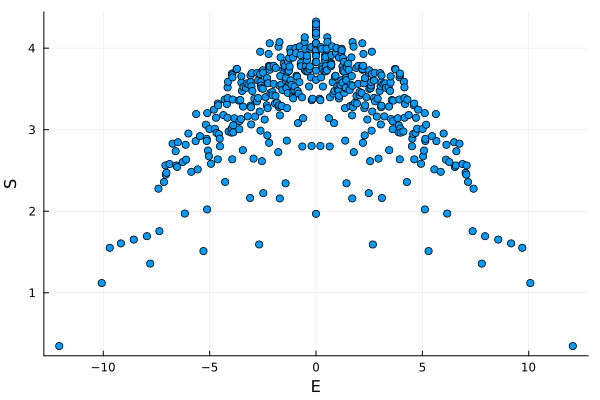

In [25]:
vals, vecs = eigen(Hermitian(H))
EE = [ent_S(vecs[:,i], 1:L÷2, basis) for i in axes(vecs, 2)]
scatter(vals, EE, xlabel="E",ylabel="S",legend=false)